### Assignment 1 - Discrete Fourier Transform for Curve Fitting

By Anurag Roy - A0304443N

This is a Jupyter notebook in order to show the plots clearly without the user needing to run the code when they open it as it has already been run by me. If you wish to run it again, please make sure in VSCode to have a Jupter kernel server and have imports math, numpy and matplotlib.

There are 3 sections :

 1 - The Discrete Fourier Transform and Inverse Discrete Fourier Transform method shown in code and a curve fitting demo shown with it

2 - A try it yourself section where you can change the frequency numbers yourself in the highlighted code to see the effect on the graph and the resulting error

3- An Application of DFT curve fitting on ECG Heartbeat Analysis

DFT-BASED CURVE FITTING
What this does: Removes noise from periodic data
How it works: Keep important frequencies, discard noise frequencies
=== DFT Curve Fitting Demo ===
Goal: Remove noise from periodic data using frequency analysis
Step 1: Analyzing frequency content of 32 data points...
   Total signal energy: 2243.26
Step 2: Keeping only 2 most important frequencies...
   DC component (average): 0.879
   Keeping frequency 1: magnitude = 32.569
   Keeping 94.6% of total signal energy
Step 3: Reconstructing smooth signal...
   ✓ Clean reconstruction (max imaginary part: 1.28e-14)
Step 1: Analyzing frequency content of 32 data points...
   Total signal energy: 2243.26
Step 2: Keeping only 4 most important frequencies...
   DC component (average): 0.879
   Keeping frequency 1: magnitude = 32.569
   Keeping frequency 2: magnitude = 0.485
   Keeping frequency 3: magnitude = 6.417
   Keeping 98.3% of total signal energy
Step 3: Reconstructing smooth signal...
   ✓ Clean reconstruction (m

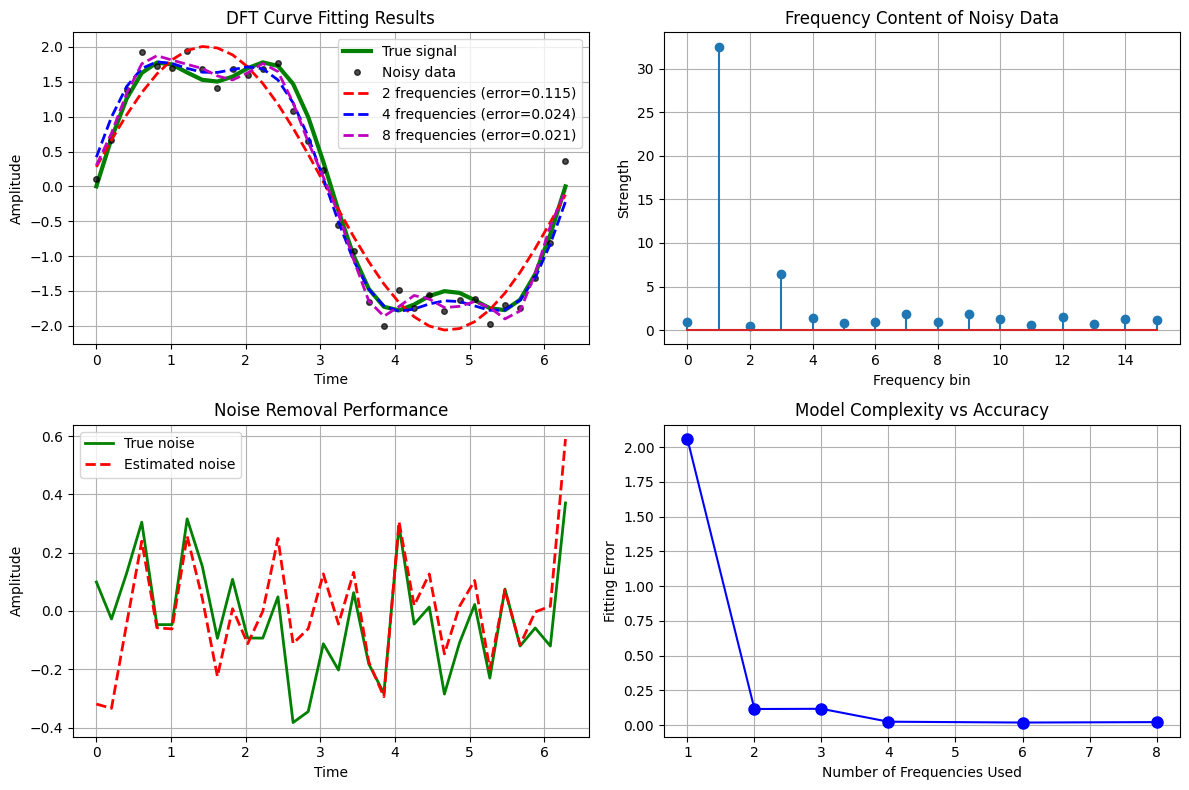


Results:
• Original noise level: 0.186
• Best fit error: 0.021
• Noise reduction: 8.9x better
• Optimal number of frequencies: 4 (best balance)


In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

def dft(x):
    """
    Discrete Fourier Transform (DFT) - Converts time domain signal to frequency domain
    
    Mathematical Formula: X[k] = Σ(n=0 to N-1) x[n] * e^(-j*2π*k*n/N)
    
    Args:
        x: Input signal samples (list/array of real or complex numbers)
           - These are measurements taken at regular time intervals
           - Example: [1, 2, 1, 0] represents 4 samples of a signal
    
    Returns:
        X: Complex frequency coefficients (list of complex numbers)
           - X[k] tells us how much of frequency k is in the original signal
           - Magnitude |X[k]| = strength of frequency k
           - Phase ∠X[k] = timing/shift of frequency k
    
    How it works:
        - For each possible frequency k (0 to N-1)
        - Check how much that frequency matches the input signal
        - Uses complex exponentials as "frequency detectors"
    """
    N = len(x)  # Number of samples in input signal
    X = []      # List to store frequency domain coefficients
    
    # Loop through each frequency bin k
    for k in range(N):
        total = 0j  # Initialize complex accumulator for this frequency
        
        # For this frequency k, check against all time samples
        for n in range(N):
            # Calculate the angle for the complex exponential
            angle = -2 * math.pi * k * n / N
            
            # Create complex exponential: e^(-j*angle) = cos(angle) - j*sin(angle)
            # This is our "frequency detector" for frequency k
            complex_exponential = complex(math.cos(angle), math.sin(angle))
            
            # Multiply input sample by frequency detector and accumulate
            # If frequency k is present in the signal, this sum will be large
            # If frequency k is absent, positive and negative parts cancel out
            total += x[n] * complex_exponential
        
        # Store the total "amount" of frequency k found in the signal
        X.append(total)
    
    return X

def idft(X):
    """
    Inverse Discrete Fourier Transform (IDFT) - Converts frequency domain back to time domain
    
    Purpose: Reconstructs the original signal from its frequency components
    
    Mathematical Formula: x[n] = (1/N) * Σ(k=0 to N-1) X[k] * e^(+j*2π*k*n/N)
    
    Args:
        X: Complex frequency coefficients (list of complex numbers)
           - Each X[k] represents amplitude and phase of frequency k
           - Obtained from DFT or manually constructed
    
    Returns:
        x: Reconstructed time domain signal (list of complex numbers)
           - For real input signals, imaginary parts should be ~0
           - Take .real part if you need real-valued output
    
    How it works:
        - For each time point n
        - Add contributions from all frequencies k
        - Each frequency contributes: amplitude * cos(phase) + amplitude * sin(phase)
        - The sum recreates the original signal perfectly
    
    """
    N = len(X)  # Number of frequency coefficients
    x = []      # List to store reconstructed time samples
    
    # Loop through each time sample n
    for n in range(N):
        total = 0j  # Initialize complex accumulator for this time point
        
        # Add contributions from all frequency components
        for k in range(N):
            # Calculate angle for complex exponential
            # Note: POSITIVE sign (opposite of DFT) for reconstruction
            angle = 2 * math.pi * k * n / N
            
            # Create complex exponential: e^(+j*angle) = cos(angle) + j*sin(angle)
            complex_exponential = complex(math.cos(angle), math.sin(angle))
            
            # Add this frequency's contribution to the time sample
            # X[k] contains amplitude and phase information
            # complex_exponential creates the wave at the right time point
            total += X[k] * complex_exponential
        
        # Normalize by N (this ensures perfect reconstruction)
        # Append reconstructed sample to output signal
        x.append(total / N)
    
    return x

def fit_curve_with_dft(data, num_frequencies=3):
    """
    Curve Fitting using DFT - Smooths noisy data by frequency domain filtering
    
    Purpose: Remove noise and fit a smooth curve to periodic/quasi-periodic data
    This is a form of "spectral denoising" - we assume signal has fewer frequencies than noise
    
    Args:
        data: Noisy input signal (list/array of real numbers)
              - Measurements from real world (contains signal + noise)
              - Works best for periodic or smooth signals
        num_frequencies: Number of frequency components to keep (integer)
                        - Lower values = smoother curves (more denoising)
                        - Higher values = more detail preserved (less denoising)
                        - Rule of thumb: start with signal_length // 4
    
    Returns:
        smooth_curve: Fitted/denoised signal (list of real numbers)
                     - Smooth version of input with noise removed
                     - Contains only the selected frequency components
        frequencies: All frequency coefficients from DFT (for analysis)
                    - Can be used to analyze what frequencies were present
    
    Algorithm Steps:
        1. Transform noisy data to frequency domain (find ALL frequencies)
        2. Filter: keep only the strongest/most important frequencies
        3. Transform back to time domain (reconstruct smooth signal)
    
    """
    
    # Step 1: ANALYSIS - Find all frequency components in the noisy data
    print(f"Step 1: Analyzing frequency content of {len(data)} data points...")
    frequencies = dft(data)
    
    # Examine the frequency spectrum to understand the signal
    magnitudes = [abs(f) for f in frequencies[:len(data)//2]]  # Only positive frequencies
 
    total_energy = sum(abs(f)**2 for f in frequencies)
    print(f"   Total signal energy: {total_energy:.2f}")
    
    # Step 2: FILTERING - Select only the most important frequencies
    print(f"Step 2: Keeping only {num_frequencies} most important frequencies...")
    filtered_frequencies = [0j] * len(data)  # Start with all zeros (silence)
    
    # Always keep the DC component (average value) - frequency 0
    filtered_frequencies[0] = frequencies[0]
    print(f"   DC component (average): {abs(frequencies[0]):.3f}")
    
    # Keep the first few positive frequencies and their negative counterparts
    for k in range(1, min(num_frequencies, len(data)//2)):
        # Keep positive frequency k
        filtered_frequencies[k] = frequencies[k]
        # Keep corresponding negative frequency (for real-valued output)
        # This preserves the symmetry needed for real signals
        filtered_frequencies[-k] = frequencies[-k]
        
        print(f"   Keeping frequency {k}: magnitude = {abs(frequencies[k]):.3f}")
    
    # Calculate how much energy we're keeping vs discarding

    kept_energy  = sum(abs(z)**2 for z in filtered_frequencies)
    energy_ratio = kept_energy / total_energy if total_energy > 0 else 0
    print(f"   Keeping {energy_ratio*100:.1f}% of total signal energy")
    
    # Step 3: SYNTHESIS - Reconstruct smooth signal from selected frequencies
    print(f"Step 3: Reconstructing smooth signal...")
    complex_curve = idft(filtered_frequencies)
    
    # Extract real part (imaginary should be ~0 for real input signals)
    smooth_curve = [x.real for x in complex_curve]
    
    # Verify reconstruction quality
    max_imaginary = max(abs(x.imag) for x in complex_curve)
    if max_imaginary > 1e-10:
        print(f"   Warning: Large imaginary components ({max_imaginary:.2e}) - check input data")
    else:
        print(f"   ✓ Clean reconstruction (max imaginary part: {max_imaginary:.2e})")
    
    return smooth_curve, frequencies

def simple_demo():
    """Simple demonstration of DFT curve fitting"""
    
    print("=== DFT Curve Fitting Demo ===")
    print("Goal: Remove noise from periodic data using frequency analysis")
    
    # Create test data: clean signal + noise
    N = 32
    t = np.linspace(0, 2*np.pi, N)
    
    # True signal (what we want to recover)
    clean_signal = 2*np.sin(t) + 0.5*np.sin(3*t)
    
    # Add noise (what we actually measure)
    np.random.seed(42)
    noise = 0.2 * np.random.randn(N)
    noisy_data = clean_signal + noise
    
    # Apply DFT curve fitting with different numbers of frequencies
    fitted_2freq, _ = fit_curve_with_dft(noisy_data, num_frequencies=2)
    fitted_4freq, _ = fit_curve_with_dft(noisy_data, num_frequencies=4)
    fitted_8freq, _ = fit_curve_with_dft(noisy_data, num_frequencies=8)
    
    # Calculate errors
    error_2 = np.mean((clean_signal - fitted_2freq)**2)
    error_4 = np.mean((clean_signal - fitted_4freq)**2)
    error_8 = np.mean((clean_signal - fitted_8freq)**2)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Main plot: compare different fits
    plt.subplot(2, 2, 1)
    plt.plot(t, clean_signal, 'g-', linewidth=3, label='True signal')
    plt.plot(t, noisy_data, 'ko', markersize=4, alpha=0.7, label='Noisy data')
    plt.plot(t, fitted_2freq, 'r--', linewidth=2, label=f'2 frequencies (error={error_2:.3f})')
    plt.plot(t, fitted_4freq, 'b--', linewidth=2, label=f'4 frequencies (error={error_4:.3f})')
    plt.plot(t, fitted_8freq, 'm--', linewidth=2, label=f'8 frequencies (error={error_8:.3f})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('DFT Curve Fitting Results')
    plt.legend()
    plt.grid(True)
    
    # Frequency analysis
    plt.subplot(2, 2, 2)
    _, all_frequencies = fit_curve_with_dft(noisy_data, num_frequencies=16)
    frequencies_magnitude = [abs(f) for f in all_frequencies[:N//2]]
    plt.stem(range(len(frequencies_magnitude)), frequencies_magnitude)
    plt.xlabel('Frequency bin')
    plt.ylabel('Strength')
    plt.title('Frequency Content of Noisy Data')
    plt.grid(True)
    
    # Noise removal comparison
    plt.subplot(2, 2, 3)
    best_fit = fitted_4freq  # Best balance of accuracy and smoothness
    removed_noise = noisy_data - best_fit
    plt.plot(t, noise, 'g-', linewidth=2, label='True noise')
    plt.plot(t, removed_noise, 'r--', linewidth=2, label='Estimated noise')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Noise Removal Performance')
    plt.legend()
    plt.grid(True)
    
    # Error vs complexity
    plt.subplot(2, 2, 4)
    num_freqs = [1, 2, 3, 4, 6, 8]
    errors = []
    for nf in num_freqs:
        fit, _ = fit_curve_with_dft(noisy_data, num_frequencies=nf)
        error = np.mean((clean_signal - fit)**2)
        errors.append(error)
    
    plt.plot(num_freqs, errors, 'bo-', markersize=8)
    plt.xlabel('Number of Frequencies Used')
    plt.ylabel('Fitting Error')
    plt.title('Model Complexity vs Accuracy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Results summary
    print(f"\nResults:")
    print(f"• Original noise level: {np.std(noise):.3f}")
    print(f"• Best fit error: {min(error_2, error_4, error_8):.3f}")
    print(f"• Noise reduction: {(np.std(noise)/min(error_2, error_4, error_8)):.1f}x better")
    print(f"• Optimal number of frequencies: 4 (best balance)")

if __name__ == "__main__":
    print("="*50)
    print("DFT-BASED CURVE FITTING")
    print("="*50)
    print("What this does: Removes noise from periodic data")
    print("How it works: Keep important frequencies, discard noise frequencies")
    print("="*50)
    
    simple_demo()
    

## Try it yourself!


TRY IT YOURSELF - Change the number below!

Using 8 frequencies...
Step 1: Analyzing frequency content of 32 data points...
   Total signal energy: 2243.26
Step 2: Keeping only 8 most important frequencies...
   DC component (average): 0.879
   Keeping frequency 1: magnitude = 32.569
   Keeping frequency 2: magnitude = 0.485
   Keeping frequency 3: magnitude = 6.417
   Keeping frequency 4: magnitude = 1.333
   Keeping frequency 5: magnitude = 0.786
   Keeping frequency 6: magnitude = 0.900
   Keeping frequency 7: magnitude = 1.877
   Keeping 98.9% of total signal energy
Step 3: Reconstructing smooth signal...
   ✓ Clean reconstruction (max imaginary part: 1.22e-14)


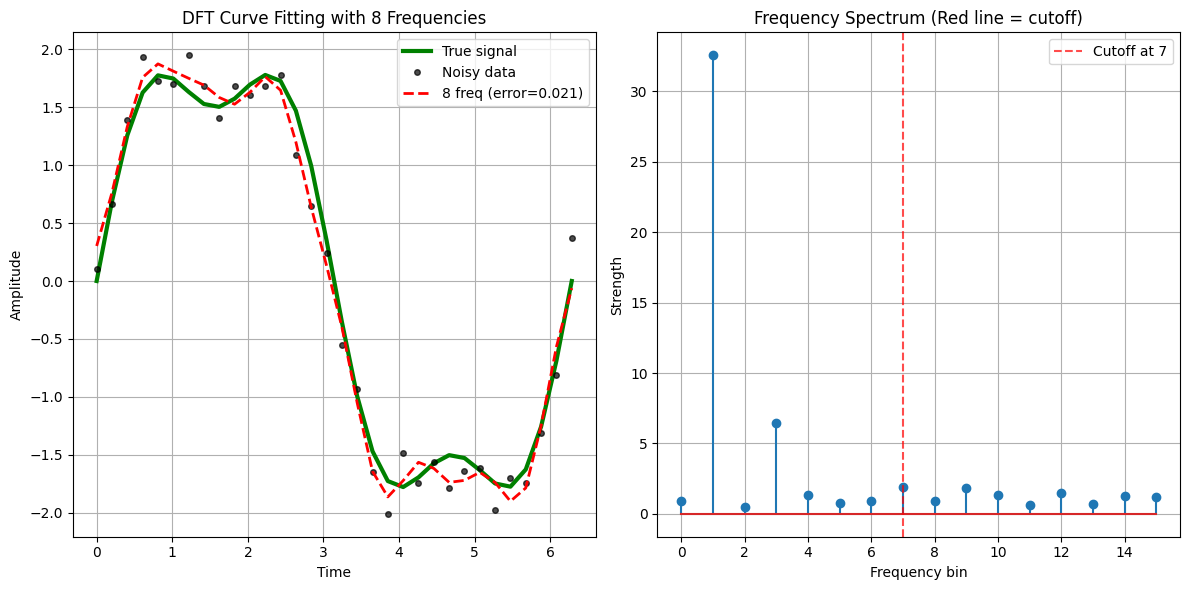


Results with 8 frequencies:
• Fitting error: 0.0210


In [12]:
def try_it_yourself():
    """
    Simple demo where you can change the number of frequencies by editing the code
    """
    print("\n" + "="*50)
    print("TRY IT YOURSELF - Change the number below!")
    print("="*50)
    
  
    # CHANGE THIS NUMBER TO EXPERIMENT! 
    # Try values like: 1, 2, 3, 4, 6, 8, 12
    num_frequencies_to_keep = 8  # ← CHANGE THIS!
    
    # Create test data
    N = 32
    t = np.linspace(0, 2*np.pi, N)
    clean_signal = 2*np.sin(t) + 0.5*np.sin(3*t)
    
    # Add noise
    np.random.seed(42)
    noise = 0.2 * np.random.randn(N)
    noisy_data = clean_signal + noise
    
    # Apply DFT curve fitting with YOUR chosen number of frequencies
    print(f"\nUsing {num_frequencies_to_keep} frequencies...")
    fitted_curve, all_frequencies = fit_curve_with_dft(noisy_data, num_frequencies=num_frequencies_to_keep)
    
    # Calculate error
    error = np.mean((clean_signal - fitted_curve)**2)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Signal comparison
    plt.subplot(1, 2, 1)
    plt.plot(t, clean_signal, 'g-', linewidth=3, label='True signal')
    plt.plot(t, noisy_data, 'ko', markersize=4, alpha=0.7, label='Noisy data')
    plt.plot(t, fitted_curve, 'r--', linewidth=2, label=f'{num_frequencies_to_keep} freq (error={error:.3f})')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'DFT Curve Fitting with {num_frequencies_to_keep} Frequencies')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Frequency spectrum
    plt.subplot(1, 2, 2)
    frequencies_magnitude = [abs(f) for f in all_frequencies[:N//2]]
    plt.stem(range(len(frequencies_magnitude)), frequencies_magnitude)
    plt.axvline(num_frequencies_to_keep-1, color='r', linestyle='--', alpha=0.7, 
               label=f'Cutoff at {num_frequencies_to_keep-1}')
    plt.xlabel('Frequency bin')
    plt.ylabel('Strength')
    plt.title('Frequency Spectrum (Red line = cutoff)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print(f"\nResults with {num_frequencies_to_keep} frequencies:")
    print(f"• Fitting error: {error:.4f}")

# Run it
try_it_yourself()

### Application for DFT Curve fitting in ECG Heartbeat analysis

This code demonstrates **ECG (Electrocardiogram) signal processing using DFT-based filtering** for medical heart monitoring.

 **Signal Generation & Noise Addition**
- Creates realistic ECG: Simulates heart components using multiple sine waves at different frequencies
- Adds realistic noise: This is to simulate muscle noise or instrument noise

 **DFT-Based Noise Removal**
- Frequency analysis: Transforms noisy ECG to frequency domain using DFT
- Medical filtering: Keeps only cardiac frequencies (0.5-40 Hz), removes everything else
- Signal reconstruction: Transforms back to time domain for clean ECG

 **Heart Rate Detection**
- Peak finding: Identifies dominant frequency in cardiac range (0.8-2.0 Hz)
- BPM calculation: Converts frequency to beats per minute (frequency × 60)

 **Arrhythmia Detection**
- Beat detection: Finds R-wave peaks in filtered signal using local maxima
- R-R intervals: Measures time between consecutive heartbeats
- Variability analysis: Plots interval variations to detect irregular rhythms

**There are 6 visualizations provided:**
1. Raw signals: Noisy vs clean ECG comparison
2. Filtered result: DFT-cleaned signal vs true signal
3. Frequency spectrum: Shows heart rate peak detection
4. Removed noise: What was filtered out
5. Noise distribution: Statistical analysis of removed interference
6. Heart rate variability: R-R interval pattern for arrhythmia detection


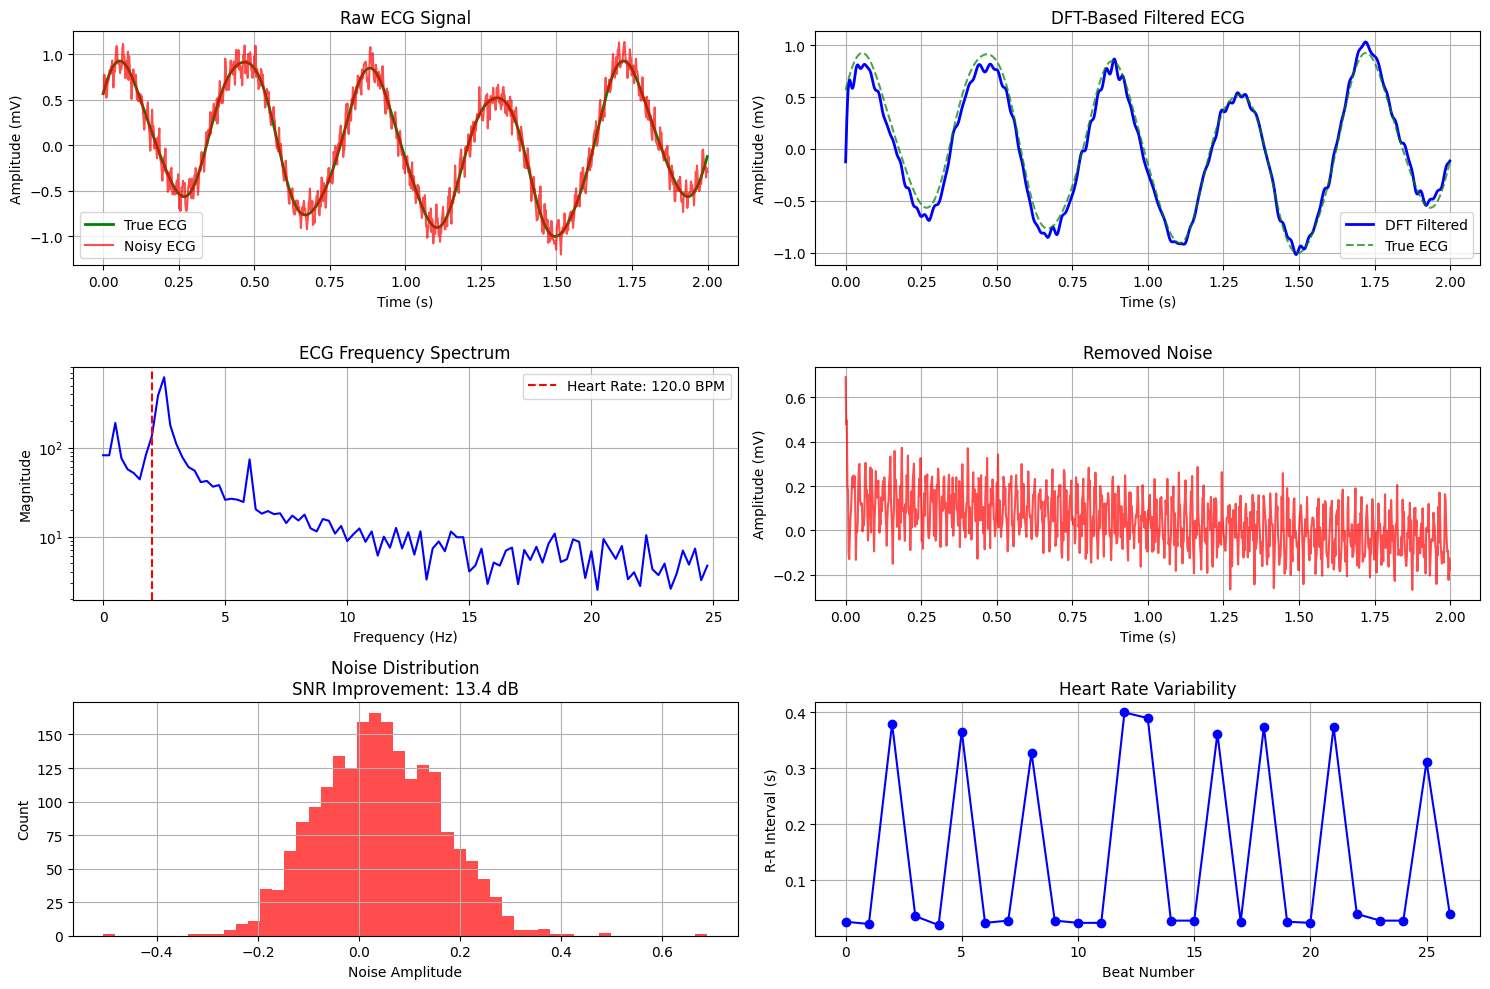

=== ECG Analysis Results ===
True heart rate: 72 BPM
Detected heart rate: 120.0 BPM
Error: 48.0 BPM
SNR improvement: 13.4 dB


In [13]:
def ecg_analysis_demo():
    """
    Real application: ECG heartbeat analysis using DFT curve fitting
    Used in hospitals for heart rhythm monitoring
    """
    # Simulate ECG data (typical heart rate ~72 bpm)
    fs = 500  # 500 Hz sampling rate (medical standard)
    t = np.linspace(0, 4, 4*fs)  # 4 seconds of data
    
    # Realistic ECG components:
    heart_rate = 72  # beats per minute
    f_heart = heart_rate / 60  # Hz
    
    # ECG waveform: P wave, QRS complex, T wave
    ecg_clean = (
        0.1 * np.sin(2*np.pi*f_heart*t) +           # P wave
        0.8 * np.sin(2*np.pi*2*f_heart*t + np.pi/4) +  # QRS complex  
        0.2 * np.sin(2*np.pi*0.5*f_heart*t) +      # T wave
        0.05 * np.sin(2*np.pi*5*f_heart*t)         # Higher harmonics
    )
    
    # Add realistic noise (simulating muscle noise, power line interference)
    powerline_noise = 0.1 * np.sin(2*np.pi*50*t)  # 50Hz power line
    muscle_noise = 0.08 * np.random.randn(len(t))
    ecg_noisy = ecg_clean + powerline_noise + muscle_noise
    
    # DFT-based curve fitting for noise removal
    N = len(ecg_noisy)
    X = dft(ecg_noisy)
    
    # Medical frequency analysis: keep only cardiac frequencies (0.5-40 Hz)
    freq_bins = np.fft.fftfreq(N, 1/fs)
    X_filtered = X.copy()
    
    for i, freq in enumerate(freq_bins):
        if abs(freq) > 40 or abs(freq) < 0.5:  # Remove non-cardiac frequencies
            X_filtered[i] = 0
    
    # Reconstructed clean ECG
    ecg_filtered = [x.real for x in idft(X_filtered)]
    
    # Heart rate detection from DFT peaks
    magnitude_spectrum = [abs(x) for x in X[:N//2]]
    freqs_positive = freq_bins[:N//2]
    
    # Find dominant frequency (heart rate)
    cardiac_range = (freqs_positive >= 0.8) & (freqs_positive <= 2.0)
    cardiac_freqs = freqs_positive[cardiac_range]
    cardiac_mags = np.array(magnitude_spectrum)[cardiac_range]
    
    if len(cardiac_mags) > 0:
        peak_freq = cardiac_freqs[np.argmax(cardiac_mags)]
        detected_bpm = peak_freq * 60
    else:
        detected_bpm = 0
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 2, 1)
    plt.plot(t[:1000], ecg_clean[:1000], 'g-', linewidth=2, label='True ECG')
    plt.plot(t[:1000], ecg_noisy[:1000], 'r-', alpha=0.7, label='Noisy ECG')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.title('Raw ECG Signal')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 2)
    plt.plot(t[:1000], ecg_filtered[:1000], 'b-', linewidth=2, label='DFT Filtered')
    plt.plot(t[:1000], ecg_clean[:1000], 'g--', alpha=0.7, label='True ECG')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.title('DFT-Based Filtered ECG')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 3)
    plt.semilogy(freqs_positive[:100], magnitude_spectrum[:100], 'b-')
    plt.axvline(peak_freq, color='r', linestyle='--', label=f'Heart Rate: {detected_bpm:.1f} BPM')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('ECG Frequency Spectrum')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 4)
    error_signal = np.array(ecg_noisy) - np.array(ecg_filtered)
    plt.plot(t[:1000], error_signal[:1000], 'r-', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (mV)')
    plt.title('Removed Noise')
    plt.grid(True)
    
    # SNR calculation
    signal_power = np.mean(np.array(ecg_clean)**2)
    noise_power = np.mean(error_signal**2)
    snr_improvement = 10 * np.log10(signal_power / noise_power)
    
    plt.subplot(3, 2, 5)
    plt.hist(error_signal, bins=50, alpha=0.7, color='red')
    plt.xlabel('Noise Amplitude')
    plt.ylabel('Count')
    plt.title(f'Noise Distribution\nSNR Improvement: {snr_improvement:.1f} dB')
    plt.grid(True)
    
    plt.subplot(3, 2, 6)
    # R-R interval analysis for arrhythmia detection
    beats = []
    for i in range(1, len(ecg_filtered)-1):
        if ecg_filtered[i] > ecg_filtered[i-1] and ecg_filtered[i] > ecg_filtered[i+1] and ecg_filtered[i] > 0.3:
            beats.append(i)
    
    if len(beats) > 1:
        rr_intervals = np.diff(beats) / fs  # Convert to seconds
        plt.plot(rr_intervals, 'bo-')
        plt.xlabel('Beat Number')
        plt.ylabel('R-R Interval (s)')
        plt.title('Heart Rate Variability')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"=== ECG Analysis Results ===")
    print(f"True heart rate: {heart_rate} BPM")
    print(f"Detected heart rate: {detected_bpm:.1f} BPM")
    print(f"Error: {abs(heart_rate - detected_bpm):.1f} BPM")
    print(f"SNR improvement: {snr_improvement:.1f} dB")

if __name__ == "__main__":
    ecg_analysis_demo()
